<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/main/notebooks/ECCB_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sequence models
good for sequence data
advantage: different lengths! shared weights (generalize things learned in some place to other places, like in CNN, otherwise too many parameters!)


sound signal, text, dna, stock price log, 

Task
sequence classification
sequence generation
translation


Data representation
 possible words/letters - one hot encoded - dictionary
 often 50 000+ words


No info from words further in the sentence - only before. Limitation. Bidirectional RNns can help.

Memory - kinda another bias (adding to new state)
 - has information about the features of the sequence processed so far



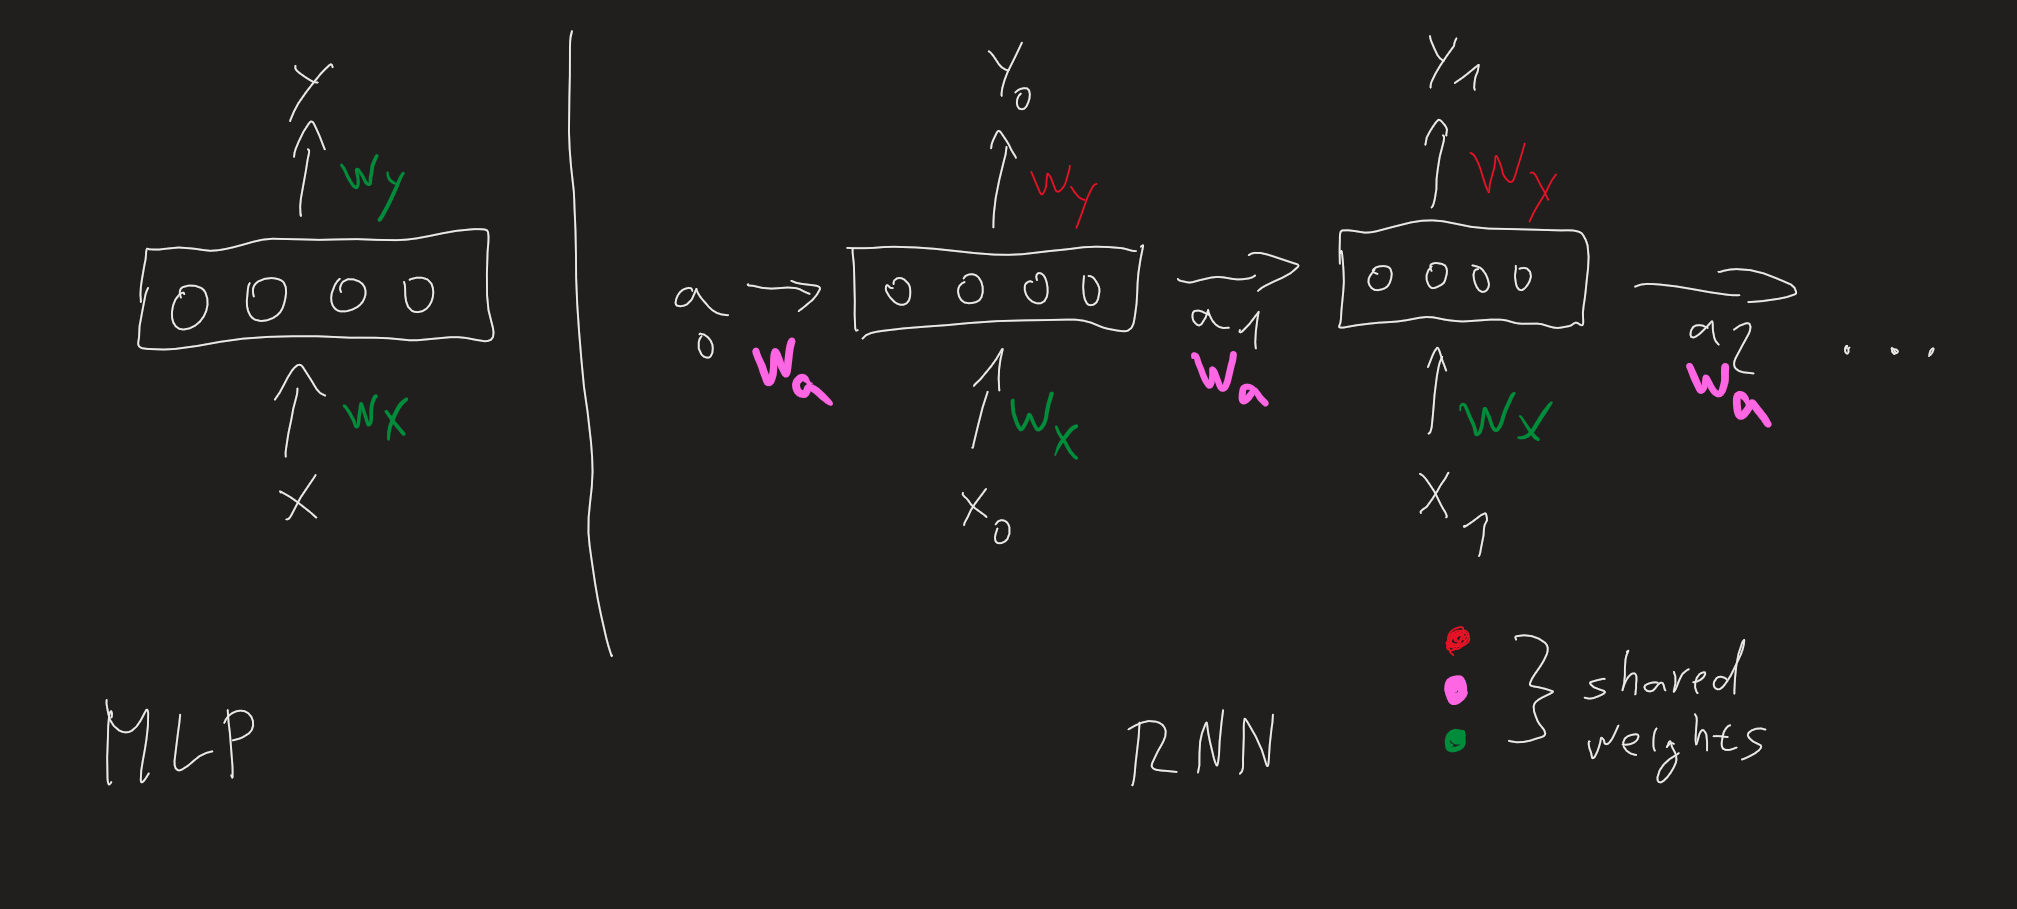

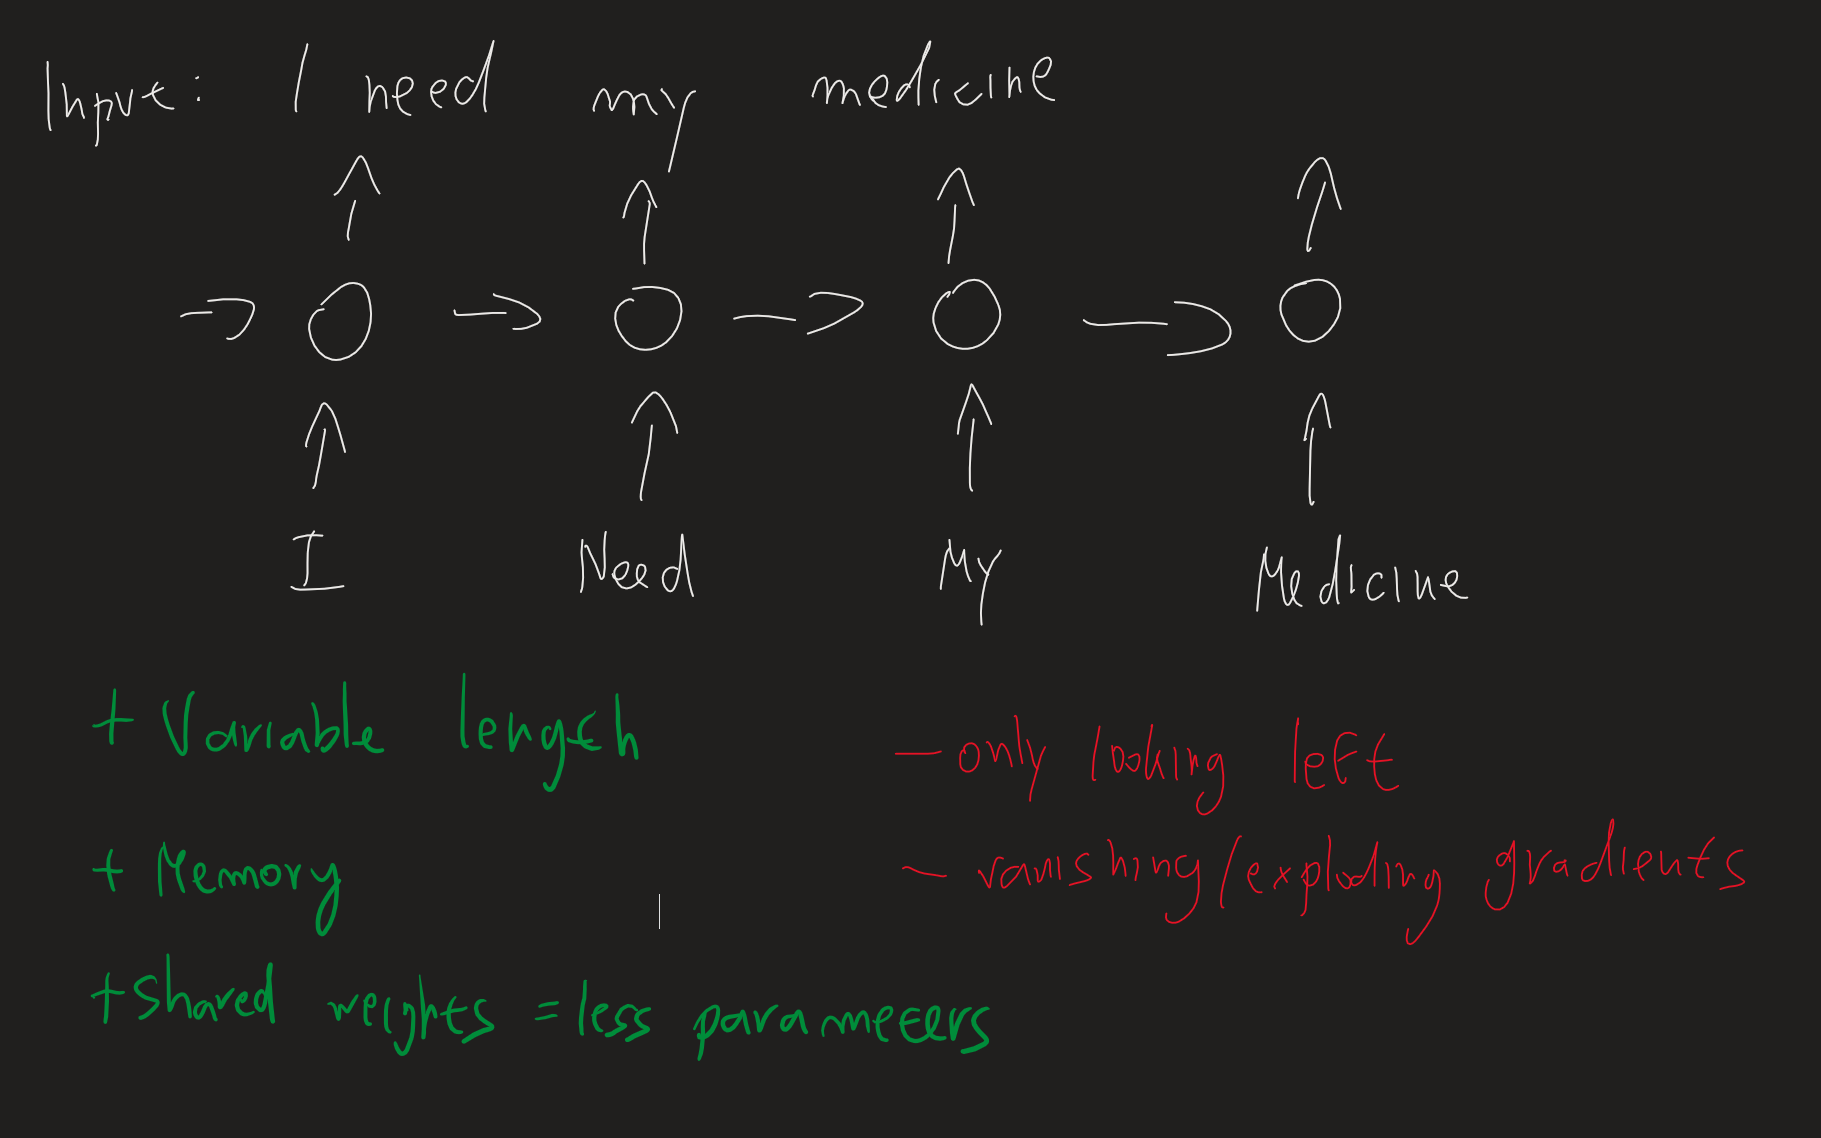

sequence generation
(output is the same length as input)
= what is the most probable next character?

creating our own dataset from jsut plain text - using semi supervised learning
#TODO explain exploding/vanishing

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Data processing

In [2]:
#DATA
#source https://www.tensorflow.org/text/tutorials/text_generation
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1122304/1115394 [==============================] - 0s 0us/step


In [3]:
# Read, then decode for py2 compat.
complete_text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(complete_text)} characters')
complete_text[:250]

Length of text: 1115394 characters


'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n'

In [4]:
# The unique characters in the file
vocab = sorted(set(complete_text))
# vocab = set(text)
print(f'{len(vocab)} unique characters')
print(vocab)

65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
chars_to_ids = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)

def text_to_ids(text, vocab=vocab):
  chars = tf.strings.unicode_split(text, input_encoding='UTF-8')
  # chars_to_ids = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)
  return chars_to_ids(chars)

text = 'Hi mom!'
ids = text_to_ids(text)
print(ids)
#Comment - tensor is just a fancy array for GPU

tf.Tensor([21 48  2 52 54 52  3], shape=(7,), dtype=int64)


In [9]:
def ids_to_text(ids):
  chars_from_ids = preprocessing.StringLookup(vocabulary=chars_to_ids.get_vocabulary(), invert=True, mask_token=None) #mask token = None - id_from_chars adds [UNK] token, not interested in that one
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy()

print(ids_to_text(ids))

b'Hi mom!'


#Creating the dataset for our model

In [10]:
all_ids = text_to_ids(complete_text)
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [14]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
seq_length=100
#We could have some sequences of length 50, some of 150 etc...!
# sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
sequences = ids_dataset.batch(seq_length, drop_remainder=True)

for s in sequences.take(3):
  print(s)
for s in sequences.take(3):
  print(ids_to_text(s))

tf.Tensor(
[19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 15 44 45 54 57 44  2 62 44
  2 55 57 54 42 44 44 43  2 40 53 64  2 45 60 57 59 47 44 57  7  2 47 44
 40 57  2 52 44  2 58 55 44 40 50  9  1  1 14 51 51 11  1 32 55 44 40 50
  7  2 58 55 44 40 50  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11
  1 38 54 60], shape=(100,), dtype=int64)
tf.Tensor(
[ 2 40 57 44  2 40 51 51  2 57 44 58 54 51 61 44 43  2 57 40 59 47 44 57
  2 59 54  2 43 48 44  2 59 47 40 53  2 59 54  2 45 40 52 48 58 47 13  1
  1 14 51 51 11  1 31 44 58 54 51 61 44 43  9  2 57 44 58 54 51 61 44 43
  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 19 48 57 58 59  7
  2 64 54 60], shape=(100,), dtype=int64)
tf.Tensor(
[ 2 50 53 54 62  2 16 40 48 60 58  2 26 40 57 42 48 60 58  2 48 58  2 42
 47 48 44 45  2 44 53 44 52 64  2 59 54  2 59 47 44  2 55 44 54 55 51 44
  9  1  1 14 51 51 11  1 36 44  2 50 53 54 62  6 59  7  2 62 44  2 50 53
 54 62  6 59  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 25 44
 59  2 

In [33]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", ids_to_text(input_example))
    print("Target:", ids_to_text(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'


In [34]:
#Only training dataset
ready_to_train_dataset = dataset.shuffle(buffer_size=10000).batch(batch_size=64)

Model

In [56]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.

model.add(layers.Embedding(input_dim=66, output_dim=256))


# Add a LSTM layer with 128 internal units.
# model.add(layers.LSTM(256, return_sequences=True)) #TODO return sequences required, otherwise error - why?

# Add a Dense layer with 10 units.
model.add(layers.Dense(66))

# model.build(input_shape=(None, 1, 66)) #Only when there is no embedding
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 256)         16896     
_________________________________________________________________
dense_20 (Dense)             (None, None, 66)          16962     
Total params: 33,858
Trainable params: 33,858
Non-trainable params: 0
_________________________________________________________________


In [23]:
len(chars_to_ids.get_vocabulary())

66

In [55]:
#TODO showcase simple vs GRU/LSTM?
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ready_to_train_dataset, epochs=3)

Epoch 1/3


ValueError: ignored

In [36]:
#copypasted model
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(chars_to_ids.get_vocabulary()),
    embedding_dim=256,
    rnn_units=256) #1024

In [37]:
#TODO showcase simple vs GRU/LSTM?
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ready_to_train_dataset, epochs=3)

Epoch 1/3
  8/175 [>.............................] - ETA: 1:35 - loss: 4.0865 - accuracy: 0.1315

KeyboardInterrupt: ignored

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

ROMEO:
Suchine to this is the lad.
Go all deadly
When with yew, and well.
My gate and it,
Where's madien sly the jid a
more name ruds; beet Sitther, nomer'd me in the raughts viral'd my formony.

KING CLERENINIS:
I pray graw; in
the viling thought like the look, think net his came
And more drave my lay exped lame thou art spy,
Where thy tale to murdinged I had of for
And ply?

First And deas, and:
Would the come, when you the talk
Yort fallow, me,
I wood a, arm to well me good of the brothed and quuech.

METRUTHIO:
Boy, thy gon tath it have was coutt shrows oble decise, and Mairings!

Pirst Cthone night me myer usbath:
To faitteral he taye?
De, and lovont
abonce: and thy comfort of naw wear
Hus to first with mike
And sceed lead aword of it.
I deads unim! Vlarings was good 'dis, wells con time in sow's and crapted thempid,
Rone count cantion: Haw?
EN sle would endy spontang to mest comcestaria.

MRONIO:
No det-mes? Cakes wear here no make wast no may. And leall inablum;
Flaid of Gadd,
T

Sequence classification [IN PROGRESS]

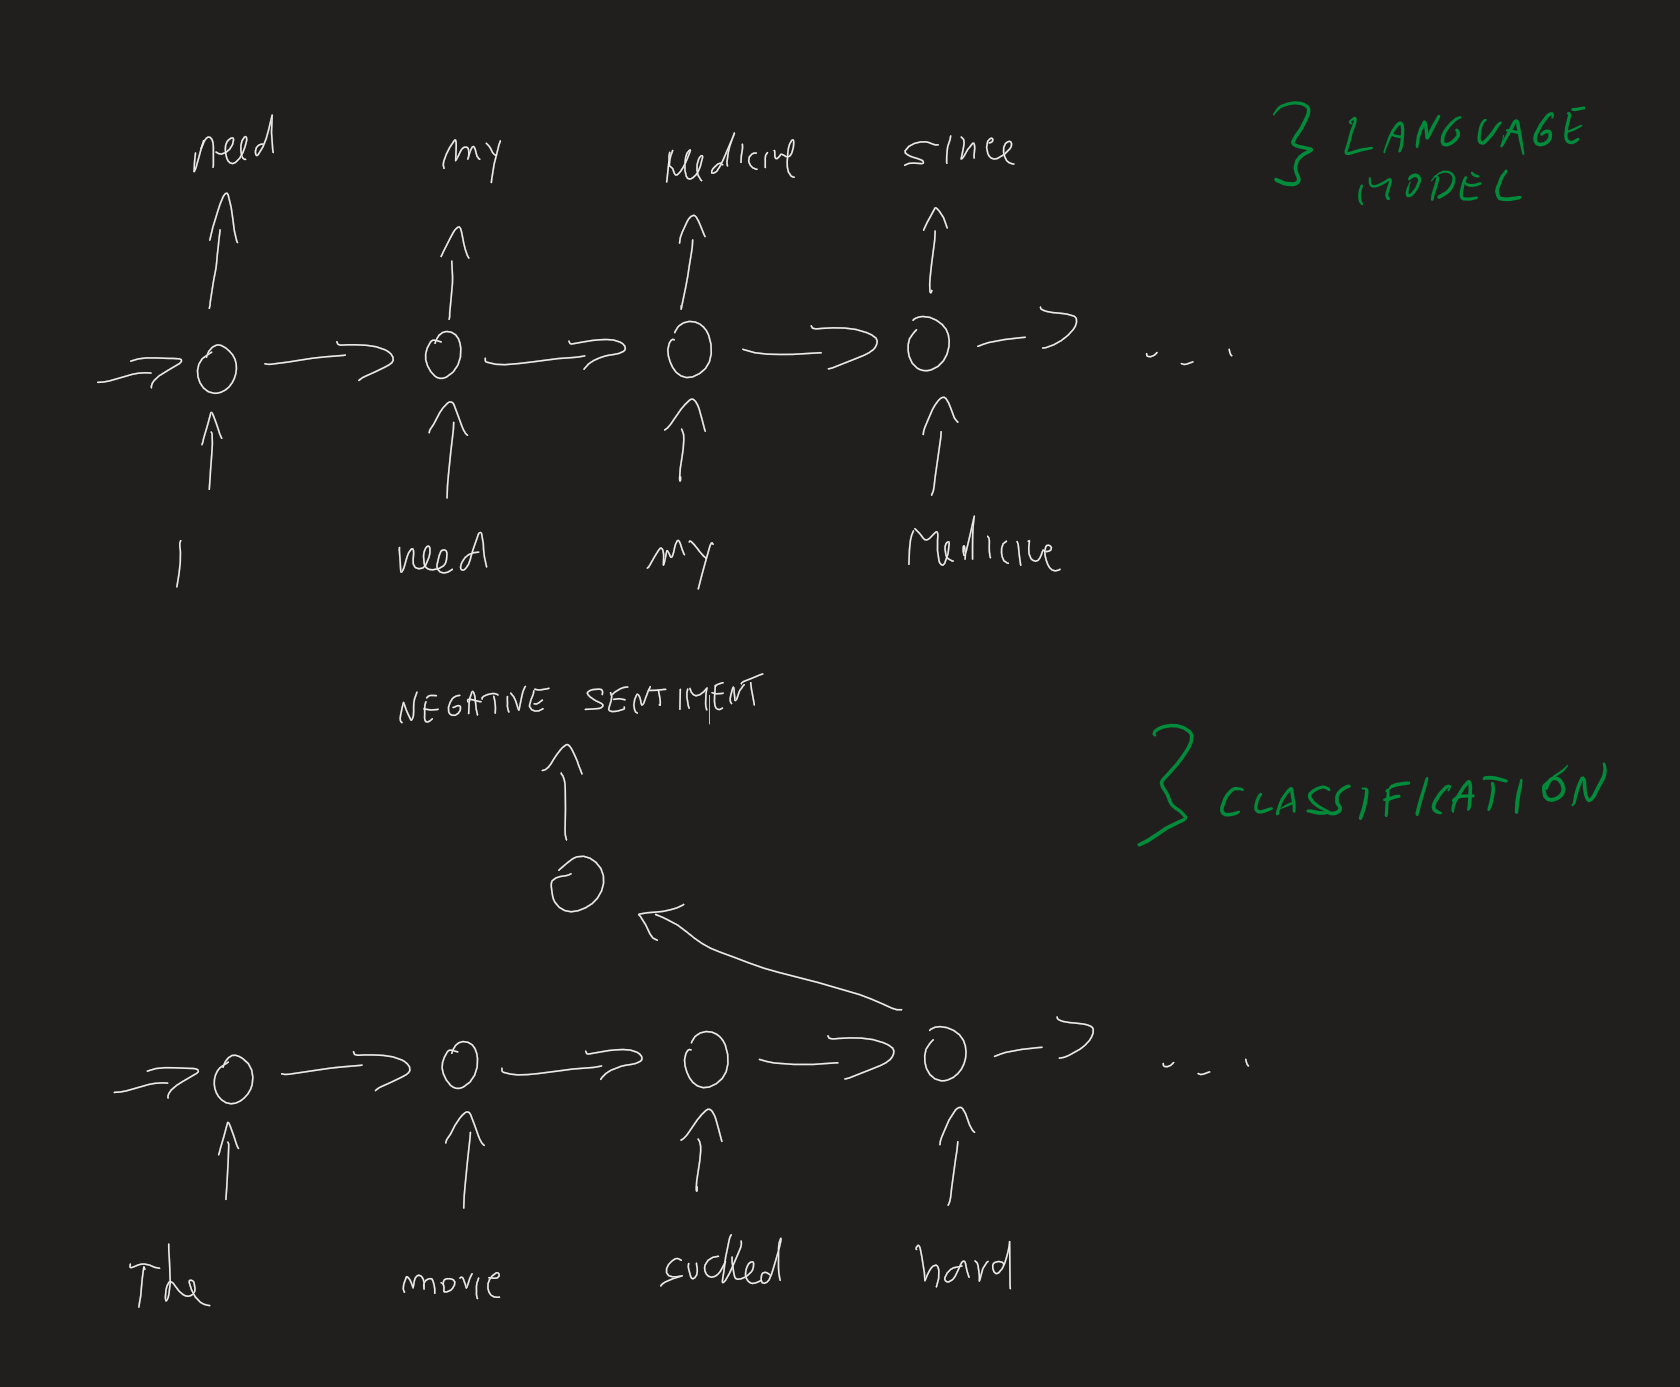

In [ ]:
#TODO https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset_og, test_dataset_og = dataset['train'], dataset['test']

train_dataset_og.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset_og.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset_og.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset_og.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
texts:  [b'This "film" attempts to follow the genre of low budget, hand-held camera flicks that have proved to be very effective and successful.<br /><br />This one, fails, and HOW.<br /><br />It\'s amazing how many so called "awards" this piece of garbage has got plast

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  20, 989, ...,   0,   0,   0],
       [  1, 779,   2, ...,   0,   0,   0],
       [  3,  11,   1, ...,   0,   0,   0]])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/3
391/391 [==============================] - 620s 2s/step - loss: 0.6372 - accuracy: 0.5699 - val_loss: 0.4779 - val_accuracy: 0.7594
Epoch 2/3
391/391 [==============================] - 606s 2s/step - loss: 0.3930 - accuracy: 0.8200 - val_loss: 0.3568 - val_accuracy: 0.8458
Epoch 3/3
391/391 [==============================] - 615s 2s/step - loss: 0.3346 - accuracy: 0.8553 - val_loss: 0.3402 - val_accuracy: 0.8531


391/391 [==============================] - 132s 337ms/step - loss: 0.3323 - accuracy: 0.8594
Test Loss: 0.332297146320343
Test Accuracy: 0.8593599796295166


(0.0, 0.6523327246308327)

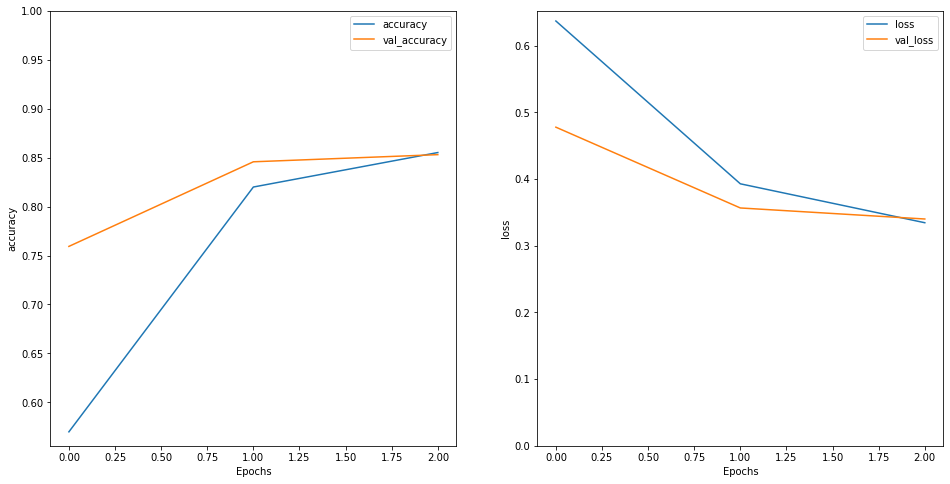

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# sample_text = ('The movie was cool. The animation and the graphics '
              #  'were out of this world. I would recommend this movie.')
sample_text = ('I did not really like the story. The effects were fine, and the overall feel was underwhelming.')
predictions = model.predict(np.array([sample_text]))
if (predictions>=0):
  print('positive') 
else: 
  print('negative')

positive
